In [114]:
import torch
from transformers import BertTokenizer, BertModel
import csv
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Function to read CSV file and extract columns
def read_csv(file_path):
    columns = {}
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for column in reader.fieldnames:
            columns[column] = []
        for row in reader:
            for column in reader.fieldnames:
                columns[column].append(row[column])
    return columns

def split_response(input):
    input = "\\n\\n1)" + input[34:-57]

    result = re.split(r'\\n\\n\d\)', input)
    for i in range(len(result)):
        result[i] = re.split(r'(\\n\d\.\d\d?|\\n\d\.\d)', result[i])

    for i in range(len(result)):
        indicesToRemove = []
        for j in range(len(result[i])):
            if len(result[i][j]) < 8:
                indicesToRemove.append(j)
        indicesToRemove.reverse()
        for j in indicesToRemove:
            result[i].remove(result[i][j])
    return result[1:]



In [115]:
gpt_separate = read_csv("C:/Users/laela/Downloads/Separate_Pairs_FINAL_Result_wGPT.csv")["GPT"]
cagpt_separate = read_csv("C:/Users/laela/Downloads/Separate_Pairs_FINAL_Result_wGPT.csv")["CAGPT"]
gpt_mixed = read_csv("C:/Users/laela/Downloads/Mixed_Pairs_FINAL_Result_wGPT.csv")["GPT"]
cagpt_mixed= read_csv("C:/Users/laela/Downloads/Mixed_Pairs_FINAL_Result_wGPT.csv")["CAGPT"]

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize the summaries and obtain BERT embeddings
gpt_embeddings = []
cagpt_embeddings = []

gpt = gpt_separate + gpt_mixed
cagpt = cagpt_separate + cagpt_mixed

for i in tqdm(range(len(gpt))):
    gpt[i] = split_response(gpt[i])
    for j in range(len(gpt[i])):
        for k in range(len(gpt[i][j])):
            gpt[i][j][k] = tokenizer.encode(gpt[i][j][k], add_special_tokens=True, truncation=True, max_length=256, return_tensors='np', padding=True)

for i in tqdm(range(len(cagpt))):
    cagpt[i] = split_response(cagpt[i])
    for j in range(len(cagpt[i])):
        for k in range(len(cagpt[i][j])):
            cagpt[i][j][k] = tokenizer.encode(cagpt[i][j][k], add_special_tokens=True, truncation=True, max_length=256, return_tensors='np', padding=True)




100%|██████████| 377/377 [00:03<00:00, 102.38it/s]


In [116]:
for i in range(len(gpt)):
    if len(gpt[i]) != 5:
        gpt.remove(gpt[i])
        i = i-1
    if i+1 == len(gpt):
        break

for i in range(len(cagpt)):
    if len(cagpt[i]) != 5:
        cagpt.remove(cagpt[i])
        i = i-1
    if i+1 == len(cagpt):
        break

In [122]:
#KMeans model
class KMeans:
    def __init__(self, n_clusters=2, max_iters=300):
        self.n_clusters = n_clusters
        self.max_iters = max_iters

    def fit(self, X):
        self.centroids = X[np.random.choice(range(len(X)), self.n_clusters, replace=False)]
        
        for _ in range(self.max_iters):
            # Assigns each data point to the nearest centroid
            clusters = [[] for _ in range(self.n_clusters)]
            for point in X:
                similarities = [np.dot(point, centroid) / (np.linalg.norm(point) * np.linalg.norm(centroid)) for centroid in self.centroids]
                closest_cluster_idx = np.argmax(similarities)
                clusters[closest_cluster_idx].append(point)
            
            # Updates centroids based on the mean of the points assigned to each cluster
            new_centroids = []
            for cluster in clusters:
                if cluster:
                    new_centroids.append(np.mean(cluster, axis=0))
                else:
                    # Doesn't change empty centroids
                    new_centroids.append(self.centroids[len(new_centroids)])
                    
            # Checks for convergence
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids

    def predict(self, X):
        predictions = []
        for point in X:
            similarities = [np.dot(point, centroid) / (np.linalg.norm(point) * np.linalg.norm(centroid)) for centroid in self.centroids]
            closest_cluster_idx = np.argmax(similarities)
            predictions.append(closest_cluster_idx)
        return np.array(predictions)

In [123]:
split_lists = [[],[],[],[],[]]
X = {}
centroids = {}
predictions = {}
split_lengths = {}
kmeans_models = [KMeans(n_clusters=2), KMeans(n_clusters=2), KMeans(n_clusters=2), KMeans(n_clusters=2), KMeans(n_clusters=2)]
for i in range(len(gpt[0])): 
    split_lengths[str(i)] = 0
    split_lengths["ca" + str(i)] = 0
    
    for j in range(len(gpt)):
        for k in range(len(gpt[j][i])):
            split_lists[i].append(gpt[j][i][k])
        
        for k in range(len(cagpt[j][i])):
            split_lists[i].append(cagpt[j][i][k])
        split_lengths[str(i)] += len(gpt[j][i])
        split_lengths["ca" + str(i)] += len(cagpt[j][i])
    
            
    # Initializes and fits the KMeans model

    max = 0
    for p in range(len(split_lists[i])):
        if len(split_lists[i][p][0]) > max:
            max = len(split_lists[i][p][0])
    
    for p in range(len(split_lists[i])):
        split_lists[i][p] = np.pad(split_lists[i][p][0], (0, max - len(split_lists[i][p][0])), mode='constant', constant_values=0)
    
    X[i] = np.array(split_lists[i])
    
    kmeans_models[i].fit(X[i])
    centroids[i] = kmeans_models[i].centroids

    # Gets cluster assignments for the data points
    predictions[i]=kmeans_models[i].predict(X[i])
    

Silhouette score for question 1 : 0.1424420777565081


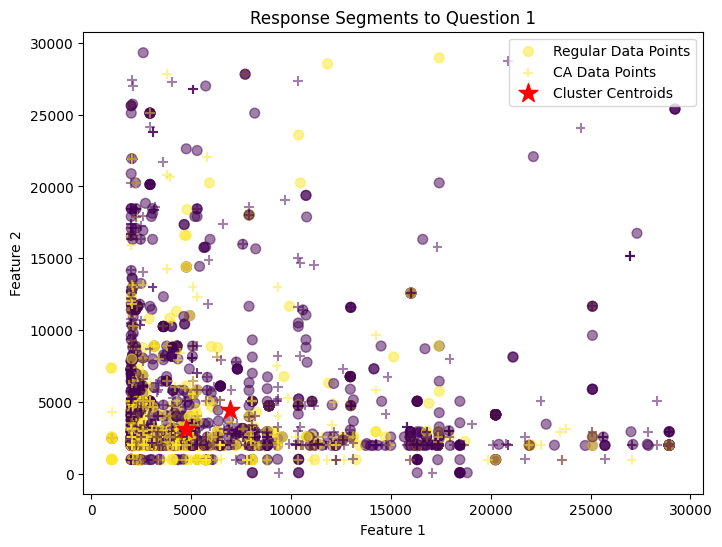

Silhouette score for question 2 : 0.23441647970697066


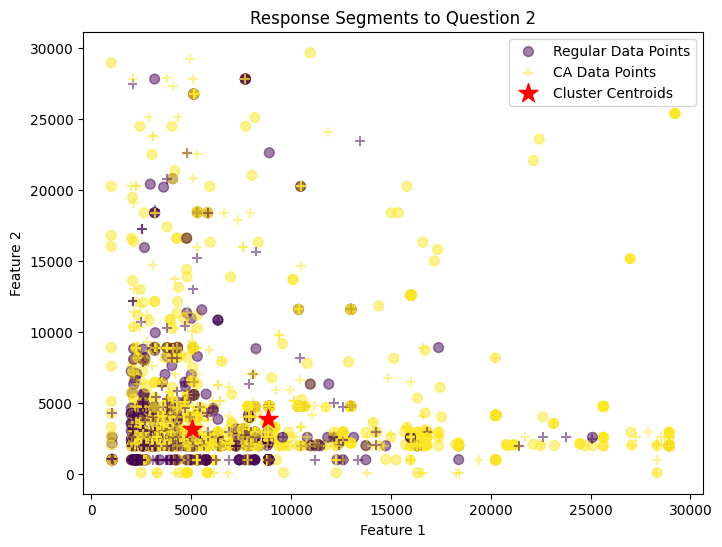

Silhouette score for question 3 : 0.11709589327478688


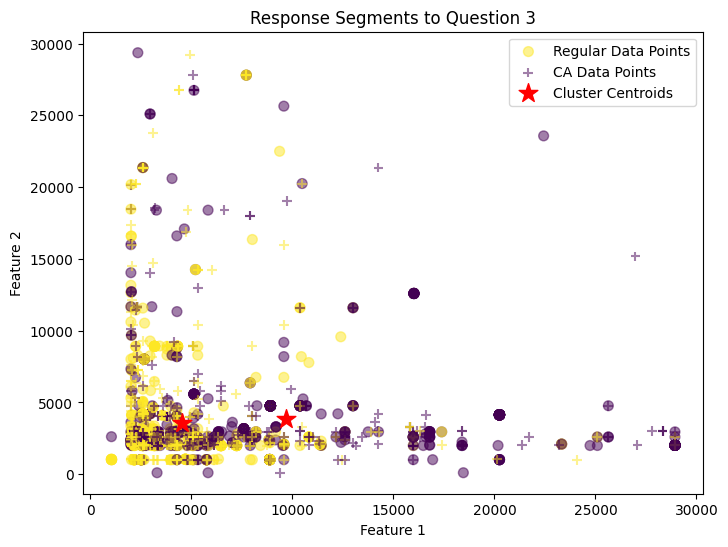

Silhouette score for question 4 : 0.08532526046964313


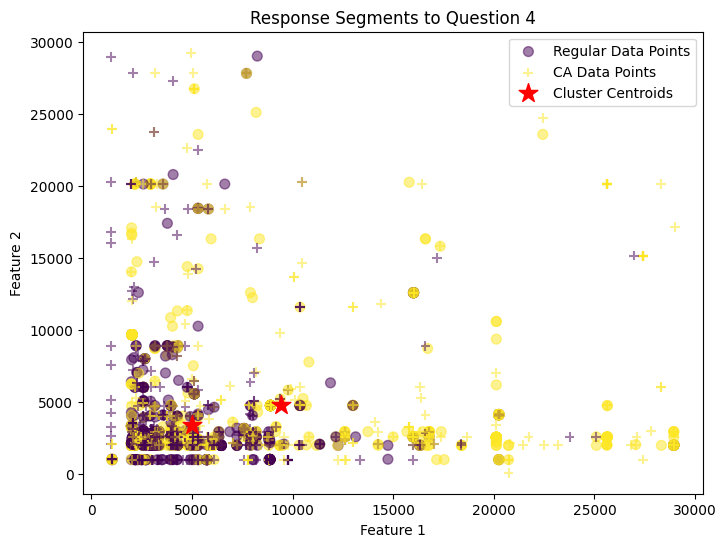

Silhouette score for question 5 : 0.05825501689144926


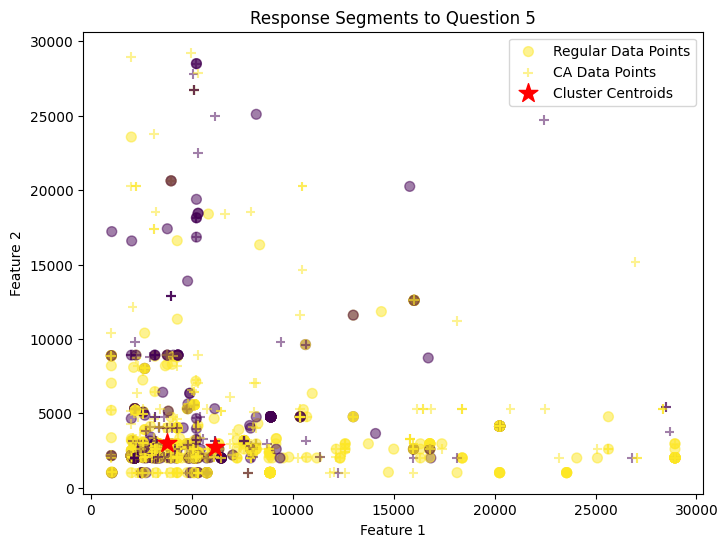

In [125]:
# Visualize the clusters
feature_1 = 1
feature_2 = 2

for i in range(len(gpt[0])):
    class_labels = [0] * split_lengths[str(i)] + [1] * split_lengths["ca"+str(i)]
    print("Silhouette score for question", str(i+1),":", silhouette_score(X[i], predictions[i]))
    centroidsToUse1 = [centroids[i][0].tolist()[feature_1], centroids[i][1].tolist()[feature_1]]
    centroidsToUse2 = [centroids[i][0].tolist()[feature_2], centroids[i][1].tolist()[feature_2]]
    plt.figure(figsize=(8, 6))
    plt.scatter(X[i][:split_lengths[str(i)], feature_1], X[i][:split_lengths[str(i)], feature_2], c=predictions[i][:split_lengths[str(i)]], s=50, cmap='viridis', alpha=0.5, label='Regular Data Points')
    plt.scatter(X[i][split_lengths[str(i)]:, feature_1], X[i][split_lengths[str(i)]:, feature_2], c=predictions[i][split_lengths[str(i)]:], s=50, cmap='viridis', alpha=0.5, label='CA Data Points', marker="+")
    plt.scatter(centroidsToUse1, centroidsToUse2, c='red', s=200, marker='*', label='Cluster Centroids')
    plt.title('Response Segments to Question ' + str(i+1))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()